# Loading raster data on to the map

In this notebook we'll take a look at using the built in tile server to render raster data to the map. The tile server used is based on [KTile](https://github.com/OpenGeoscience/KTile) a fork of TileStache and is directly integrated into the Jupyter Notebook. The GeoJS map uses this tile server to render data efficiently to the map for visualization. 

In [3]:
%matplotlib inline
from matplotlib import pylab as plt

## Get data from S3

For this notebook we'll get some sample data from S3.  This GeoTiff represents NBAR data for September from 2010 covering a section of Washington states Glacier National Park. It is aproximately 200Mb and may take some time to download from Amazon's S3.

The tiff itself has been slightly transformed from its original HDF dataset. In particular it only has 4 bands (R,G,B & NDVI) and includes some geotiff tags with band statistics.

In [2]:
!curl -o /tmp/L57.Globe.month09.2010.hh09vv04.h6v1.doy247to273.NBAR.v3.0.tiff https://data.kitware.com/api/v1/file/58dd384a8d777f0aef5d8cc2/download

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  210M  100  210M    0     0  3030k      0  0:01:10  0:01:10 --:--:-- 4377k:09 4370k


## Adding an RGB layer to the map

Here we add our first data layer to the map. To do this we use a ```RasterData``` object imported from the geonotebook.wrappers package. By default RasterData objects read tiffs using the ```rasterio``` library.  RasterData objects are designed to provide a consistent API to raster data across a number of different readers and systems. We will use the ```add_layer``` function to add the RasterData object to the map.

In [4]:
# Set the center of the map to the location the data
M.set_center(-120.32, 47.84, 7)

In [5]:
from geonotebook.wrappers import RasterData

rd = RasterData('file:///tmp/L57.Globe.month09.2010.hh09vv04.h6v1.doy247to273.NBAR.v3.0.tiff')
rd

To add the layer we call ```M.add_layer``` passing in a subset of the raster data set's bands. In this case we index into ```rd``` with the list [1, 2, 3].  This actually returns a new RasterData object with only three bands available (in this case bands 1, 2 and 3 corrispond to Red, Green and Blue).  When adding layers you can only add a layer with either 3 bands (R,G,B)  or one band (we'll see a one band example in a moment).

In [6]:
M.add_layer(rd[1, 2, 3], opacity=1.0, gamma=2.5)

This should have added an RGB dataset to the map for visualization.  You can also see what layers are available via the ```M.layers``` attribute.

In [8]:
M.layers

<GeonotebookLayerCollection([<SimpleLayer('L57.Globe.month09.2010.hh09vv04.h6v1.doy247to273.NBAR.v3.0')>])>

The dataset may appear alarmingly dark.  This is because the data itself is not well formated. We can see this by looking at band min and max values:

In [9]:
print("Color   Min               Max")
print("Red:   {}, {}".format(rd[1].min, rd[1].max))
print("Green: {}, {}".format(rd[2].min, rd[2].max))
print("Blue:  {}, {}".format(rd[3].min, rd[3].max))

Color   Min               Max
Red:   -0.0255999993533, 1.60000002384
Green: -0.0206000003964, 1.60000002384
Blue:  -0.0483000017703, 1.60000002384


R,G,B values should be between 0 and 1. We can remedy this by changing some of the styling options that are available on the layers including setting an interval for scaling our data, and setting a gamma to brighten the image.  

First we'll demonstrate removing the layer:

In [10]:
M.remove_layer(M.layers[0])

Then we can re-add the layer with a color interval of 0 to 1. 

In [11]:
M.add_layer(rd[1, 2, 3], interval=(0,1))

We can also brighten this up by changing the gamma. 

*Note* We don't have to remove the layer before updating it's options.  Calling ```M.add_layer(...)``` with the same ```rd``` object will simply replace any existing layer with the same name.  By default the layer's name is inferred from the filename.

In [13]:
M.remove_layer(M.layers[0])
M.add_layer(rd[1, 2, 3], interval=(0,1), gamma=0.5)

Finally,  let's add a little opacity to layer so we can see some of the underlying base map features.

In [14]:
M.remove_layer(M.layers[0])
M.add_layer(rd[1, 2, 3], interval=(0,1), gamma=0.5, opacity=0.75)

In [15]:
# Remove the layer before moving on to the next section
M.remove_layer(M.layers[0])

## Adding a single band Layer

Adding a single band layer uses the same ```M.add_layer(...)``` interface.  Keep in mind that several of the styling options are slightly different.  By default single band rasters are rendered with a default mapping of colors to band values.

In [16]:
M.add_layer(rd[4])

You may find this colormap a little *aggressive*,  in which case you can replace the colormap with any of the built in [matplotlib colormaps](http://matplotlib.org/users/colormaps.html):

In [17]:
M.remove_layer(M.layers[0])

cmap = plt.get_cmap('winter', 10)
M.add_layer(rd[4], colormap=cmap, opacity=0.8)

Including custom color maps as in this example.  Here we create a linear segmented colormap that transitions from Blue to Beige to Green. When mapped to our NDVI band data -1 will appear blue,  0 will appear beige  and 1 will appear green.

In [18]:
from matplotlib.colors import LinearSegmentedColormap

M.remove_layer(M.layers[0])

# Divergent Blue to Beige to Green colormap
cmap =LinearSegmentedColormap.from_list(
  'ndvi', ['blue', 'beige', 'green'], 20)

# Add layer with custom colormap
M.add_layer(rd[4], colormap=cmap, opacity=0.8, min=-1.0, max=1.0)

# What can I do with this data?

We will address the use of annotations for analysis and data comparison in a separate notebook.  For now Let's focus on a small agricultural area north of I-90:

In [19]:
M.set_center(-119.25618502500376, 47.349300631765104, 11)

Go ahead and start a rectangular annotation (Second button to the right of the 'CellToolbar' button - with the square icon). 

    Please annotate a small region of the fields.
    
We can access this data from from the annotation's ```data``` attribute. We'll cover exactly what is going on here in another notebook.

In [20]:
layer, data = next(M.layers.annotation.rectangles[0].data)
data

masked_array(data =
 [[ 0.161       0.191       0.1707     ...,  0.1697      0.17460001  0.1523    ]
 [ 0.2015      0.2015      0.2148     ...,  0.1584      0.1728      0.1973    ]
 [ 0.227       0.2015      0.1847     ...,  0.17        0.19059999  0.2006    ]
 ..., 
 [ 0.1608      0.1785      0.1785     ...,  0.1838      0.1841      0.2007    ]
 [ 0.1785      0.1761      0.1608     ...,  0.2009      0.20389999
   0.17309999]
 [ 0.1814      0.1964      0.1577     ...,  0.2079      0.2009      0.18709999]],
             mask =
 False,
       fill_value = -9999.0)

As a sanity check we can prove the data is the region we've selected by plotting the data with matplotlib's [imshow](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow) function:

*Note* The scale of the matplotlib image may seem slightly different than the rectangle you've selected on the map.  This is because the map is displaying in [Web Mercator](https://en.wikipedia.org/wiki/Web_Mercator) projection (EPSG:3857) while imshow is simply displaying the raw data, selected out of the geotiff (you can think of it as being in a 'row', 'column' projection).

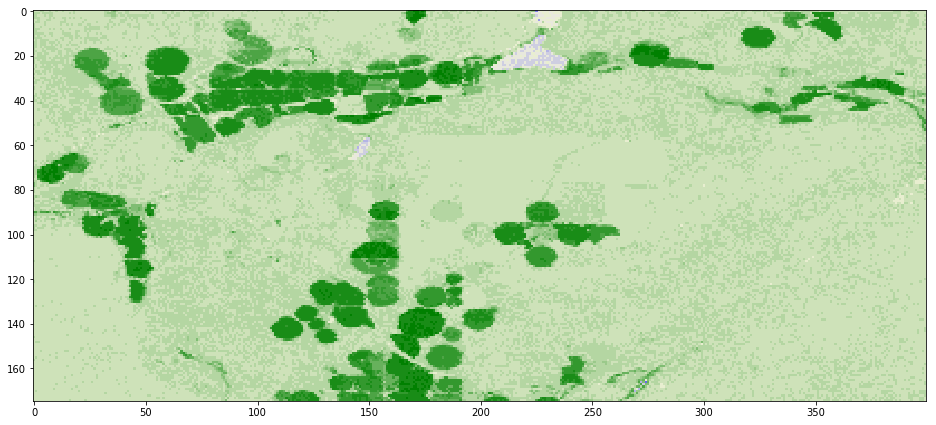

In [21]:
import numpy as np

fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(data, interpolation='none', cmap=cmap, clim=(-1.0, 1.0))

### NDVI Segmentation analysis

Once we have this data we can run arbitrary analyses on it.  In the next cell we use a sobel filter and a watershed transformation to generate a binary mask of the data.  We then use an implementation of marching cubes to vectorize the data,  effectively segmenting green areas (e.g. fields)  from surrounding areas.

This next cell requires both [scipy](https://www.scipy.org/) and [scikit-image](http://scikit-image.org/). Check your operating system documentation for how best to install these packages.

In [22]:
# Adapted from the scikit-image segmentation tutorial
# See: http://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html
import numpy as np

from skimage import measure
from skimage.filters import sobel
from skimage.morphology import watershed
from scipy import ndimage as ndi


THRESHOLD = 20
WATER_MIN = 0.2
WATER_MAX = 0.6

fig, ax = plt.subplots(figsize=(16, 16))
edges = sobel(data)


markers = np.zeros_like(data)
markers[data > WATER_MIN] = 2
markers[data > WATER_MAX] = 1


mask = (watershed(edges, markers) - 1).astype(bool)
seg = np.zeros_like(mask, dtype=int)
seg[~mask] = 1

# Fill holes
seg = ndi.binary_fill_holes(seg)

# Ignore entities smaller than THRESHOLD
label_objects, _ = ndi.label(seg)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > THRESHOLD
mask_sizes[0] = 0

clean_segs = mask_sizes[label_objects]


# Find contours of the segmented data
contours = measure.find_contours(clean_segs, 0)
ax.imshow(data, interpolation='none', cmap=cmap, clim=(-1.0, 1.0))

ax.axis('tight')

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=4)
  